## Importing Packages

In [1]:
# Importing (using/include) packages and files needed for the code to run 
using SparseArrays
using LinearAlgebra
using IterativeSolvers
using WriteVTK
using Printf
using Statistics 
include("Grid.jl")
include("Markers.jl")
include("Stokes.jl")
include("Temperature.jl")
include("GridOperations.jl")

# Note: that we import pyplot last to avoid a name conflict with grid
using PyPlot
include("Visualization.jl")

plots (generic function with 1 method)

# Topography Setup

In [2]:
# The initial topography setup follows the following:
# y = A * [sin(B(x-C))] + D 
# |A| is the amplitude 
# The period is 2π/B 
# Phase(horizontal) shift is C 
# Vertical shift is D 

function initial_ice_depth(x::Float64)
    return (0.1*90000.0)*(sin(x*(2*pi/90000.0)))+(0.5*90000.0)
    #return (0.05*90000.0)*(sin(x*(2*pi/90000.0)))+(0.5*90000.0)
end

function initial_surface_depth(x::Float64)
     return 3e4
end

function ice_viscosity(T::Float64)
    Q = 40000.0 # Activation Enegry
    R_cont = 8.314 # Gas Constant 
    return (1e15)*exp((Q*(273.0-T))/(R_cont*(273.0*T)))
end


# # Creating a function to assign viscosity if eta is not constant
# function compute_variable_eta(markers::Markers,materials::Materials)
#     t_icy = zeros(1,markers.nmark)
#     eta_i = zeros(1,markers.nmark)
#     for i in 1:markers.nmark
#         mx = markers.x[1,i]
#         my = markers.x[2,i]
#         h = initial_ice_depth(mx)
#         hsurf = initial_surface_depth(mx)
#         if my < h
#             t_icy[i] = 100.0+((273.0-100.0)/(h-hsurf))*(my-hsurf)
#             eta_i[i] = (1e15)*exp((Q*(273.0-t_icy[i]))/(R_cont*(273.0*t_icy[i])))
#         end
#     end 
#     return t_icy,eta_i
# end


ice_viscosity (generic function with 1 method)

# Material Setup

In [3]:
struct Materials
    # 1 - subsurface global ocean
    # 2 - icy shell
    # 3 - sticky air
    alpha::Vector{Float64}
    rho0::Vector{Float64}
    Hr::Vector{Float64}
    Cp::Vector{Float64}
    kThermal::Vector{Float64}
    eta::Vector{Float64}
    function Materials()
        new([0.0,0.0,0.0],[1000.0,920.0,1.0],[0.0,0.0,0.0],[4180.0,2100,1e6],[0.5610,2.22,0.024],[1e12,1e15,1e17])
    end    
end

function update_marker_viscosity!(markers::Markers,materials::Materials)
    eta = markers.scalarFields["eta"]
    T = markers.scalarFields["T"]
    mmat = markers.integers[markers.integerFields["material"],:]
    for i in 1:markers.nmark
        if mmat[i] == 2
            markers.scalars[eta,i] = ice_viscosity( markers.scalars[T,i] )
        end
    end
end


function update_marker_density!(markers::Markers,materials::Materials)
    rho = markers.scalarFields["rho"]
    T = markers.scalarFields["T"]
    mmat = markers.integers[markers.integerFields["material"],:]
    for i in 1:markers.nmark                
        markers.scalars[rho,i] = materials.rho0[mmat[i]]
    end
end


function initial_conditions!(markers::Markers,materials::Materials)
    material = markers.integerFields["material"]
    T = markers.scalarFields["T"]
    eta = markers.scalarFields["eta"]
    alpha = markers.scalarFields["alpha"]
    Cp = markers.scalarFields["Cp"]
    Hr = markers.scalarFields["Hr"]
    
    for i in 1:markers.nmark
        mx = markers.x[1,i]
        my = markers.x[2,i]
        hice = initial_ice_depth(mx)
        hsurf = initial_surface_depth(mx)
        if my > hice
            # subsurface global ocean
            markers.integers[material,i] = 1
            markers.scalars[T,i] = 273.0
            markers.scalars[eta,i] = materials.eta[1]
            markers.scalars[alpha,i] = materials.alpha[1]        
            markers.scalars[Cp,i] = materials.Cp[1]
            markers.scalars[Hr,i] = materials.Hr[1]  
        elseif my > hsurf
            # icy shell
            markers.integers[material,i] = 2
            markers.scalars[T,i] = 100.0+((273.0-100.0)/(hice-hsurf))*(my-hsurf)
            # markers.scalars[eta,i] = eta_i[i]
            markers.scalars[alpha,i] = materials.alpha[2]
            markers.scalars[Cp,i] = materials.Cp[2]
            markers.scalars[Hr,i] = materials.Hr[2]  
        else
            # sticky air
            markers.integers[material,i] = 3
            markers.scalars[T,i] = 100.0            
            markers.scalars[eta,i] = materials.eta[3]
            markers.scalars[alpha,i] = materials.alpha[3]  
            markers.scalars[Cp,i] = materials.Cp[3]
            #markers.scalars[Hr,i] = materials.Hr[3] 
        end
    end 
    # end loop over markers
    update_marker_viscosity!(markers,materials)
    update_marker_density!(markers,materials)
end

initial_conditions! (generic function with 1 method)

# Model Setup

In [4]:
function run(nstep::Int64)
    nstep=1
    nx = 101
    ny = 101
    W = 90000.0
    H = 90000.0
    gx = 0.0
    gy = 1.3
   
    Tbctype = [-1,-1,1,1] #left, right, top, bottom
    Tbcval = [0.0,0.0,100.0,273.0] #left, right, top, bottom
    bc = BoundaryConditions(0,0,0,0) # currently does nothing but is required argument to stokes solver.
    materials = Materials()
    
    markx = 6
    marky = 6
    seconds_in_year = 3.15e7
    plot_interval = 1e6*seconds_in_year # plot interval in seconds
    end_time = 3e7*seconds_in_year
    dtmax = plot_interval
    grid = CartesianGrid(W,H,nx,ny)
    println("Creating Markers...")
    @time markers = Markers(grid,["alpha","T","rho","eta","Cp","Hr"],["material"] ; nmx=markx,nmy=marky,random=true)
    println("Initial condition...")
    @time initial_conditions!(markers, materials)

    # define arrays for k, rho, cp, H at the basic nodes. Fill them with constant values for now.
    kThermal = 3.0 .*ones(grid.ny,grid.nx);
    
    time = 0.0
    iout=0
    last_plot = 0.0
    rho_c = nothing
#     eta_s = nothing
#     Hr = nothing
#     Cp_c = nothing
#     alpha = nothing
#     eta_n = nothing
#     Tlast = nothing
#     rho_vx = nothing 
#     rho_vy = nothing
    dt = 1e10

    local rho_c 
    local rho_vx
    local rho_vy
    local alpha
    local Hr
    local Cp_c
    local eta_s
    local eta_n
    local vxc
    local vyc
    local T
    local dt
    local dTmax
    local dTemp
    local Tnew
    local Tlast

    output_dir = "test"
    for itime in 1:nstep
        # 0. update the viscosity and the density on the markers
        update_marker_viscosity!(markers,materials)
        # 1. Transfer properties markers -> nodes
        # 1a. Basic Nodes
        eta_s_new, = marker_to_stag(markers,grid,["eta",],"basic");
        # 1b. Cell Centers
        rho_c_new,Cp_c_new,alpha_new,eta_n_new,Tlast_new,Hr_new = marker_to_stag(markers,grid,["rho","Cp","alpha","eta","T","Hr"],"center")
        # 1c. Vx and Vy nodes:
        rho_vx_new, = marker_to_stag(markers,grid,["rho",],"vx")
        rho_vy_new, = marker_to_stag(markers,grid,["rho",],"vy") 
       
        # deal with any NaN values from interpolation:
        if itime > 1
            if any(isnan.(eta_s_new))
                println("found nan values")
            end
            replace_nan!(eta_s,eta_s_new)
            replace_nan!(rho_c,rho_c_new)
            replace_nan!(Hr,Hr_new)
            replace_nan!(Cp_c,Cp_c_new)
            replace_nan!(alpha,alpha_new)
            replace_nan!(eta_n,eta_n_new)
            replace_nan!(Tlast,Tlast_new)
            replace_nan!(rho_vx,rho_vx_new)
            replace_nan!(rho_vy,rho_vy_new)
        end
        # Copy field data 
        rho_vx = copy(rho_vx_new)
        rho_vy = copy(rho_vy_new)
        rho_c = copy(rho_c_new)
        Hr = copy(Hr_new)
        Cp_c = copy(Cp_c_new)
        alpha = copy(alpha_new)
        eta_s = copy(eta_s_new)
        eta_n = copy(eta_n_new)
        Tlast = copy(Tlast_new)

        # 2. Assemble and solve the stokes equations
        L,R = form_stokes(grid,eta_s,eta_n,rho_vx,rho_vy,bc,gx,gy,dt=dt)
        stokes_solution = L\R
        vx,vy,P = unpack(stokes_solution,grid;ghost=true)
    
        # Get the velocity at the cell centers:
        vxc,vyc = velocity_to_centers(grid,vx,vy)
        adiabatic_heating = compute_adiabatic_heating(grid,rho_c,Tlast,alpha,gx,gy,vxc,vyc)
        shear_heating = compute_shear_heating(grid,vx,vy,eta_n,eta_s)
        H = (adiabatic_heating .+ shear_heating .+ Hr)
    
    
        # 3. Compute the advection timestep:
        if itime > 1
            this_dtmax = min(1.2*dt,dtmax)
        else
            this_dtmax = dtmax
        end
        dt = compute_timestep(grid,vxc,vyc ; dtmax=this_dtmax)

        dTmax = Inf
        dTemp = nothing
        Tnew = nothing
        titer = 1
        for titer=1:2
            # assemble and solve the energy equation
            println("Trying with timestep ",dt)
            L,R = assemble_energy_equation_center(grid,rho_c,Cp_c,kThermal,H,Tlast,dt,Tbcval);
            Tnew = L\R;
            Tnew = reshape(Tnew,grid.ny,grid.nx);
            Tnew = ghost_temperature_center(grid,Tnew,Tbctype,Tbcval);

            T = copy(Tnew)

            dTemp = Tnew-Tlast
            # compute the maximum temperature change
            dTmax = maximum(abs.(dTemp))
            println("dTmax=",dTmax," dt=",dt/3.15e7/1e6)
            dt = min(dt,dTmax < 10.0 ? dt : dt*10.0/dTmax)
            if dTmax < 10.0
                break
            end
        end

        dT_subgrid_node = subgrid_temperature_relaxation_center!(markers,grid,Tlast,Cp_c[1,1],kThermal[1,1],dt)
        dT_remaining = dTemp - dT_subgrid_node
    
        cell_center_change_to_markers!(markers,grid,dT_remaining,"T")

#         if time == 0.0 || time - last_plot >= plot_interval
#             last_plot = time 
#             name = @sprintf("%s/viz.%04d.vtr",output_dir,iout)
#             vn = velocity_to_basic_nodes(grid,vxc,vyc)

#         visualization(grid,rho_c,eta_s,vn,P,Tnew[2:end-1,2:end-1],time/seconds_in_year;filename=name)
#             name = @sprintf("%s/markers.%04d.vtp",output_dir,iout)
#             visualization(markers,time/seconds_in_year;filename=name)
#             iout += 1
#         end

        
        println("Min/Max velocity: ",minimum(vyc)," ",maximum(vyc))
        move_markers_rk4!(markers,grid,vx,vy,dt,continuity_weight=1/3)
        time += dt
        println("Finished Step ",itime," time=",time/seconds_in_year/1e6," Myr")
    end
    return grid,markers,vxc,vyc,rho_c,eta_n,Tnew,time
end
@time grid,markers,vxc,vyc,rho_c,eta_n,Tnew,time = run(1)
# 1 Myr = 1000 thousand year
figure()
scatter(markers.x[1,:],markers.x[2,:],c="b",s=0.1)
show()

Creating Markers...
  0.123945 seconds (152.08 k allocations: 41.491 MiB, 5.70% gc time, 84.38% compilation time)
Initial condition...
  0.210442 seconds (1.63 M allocations: 29.250 MiB, 31.44% compilation time: 23% of which was recompilation)


LoadError: UndefVarError: marker_to_basic_node not defined

# Finding Interfaces

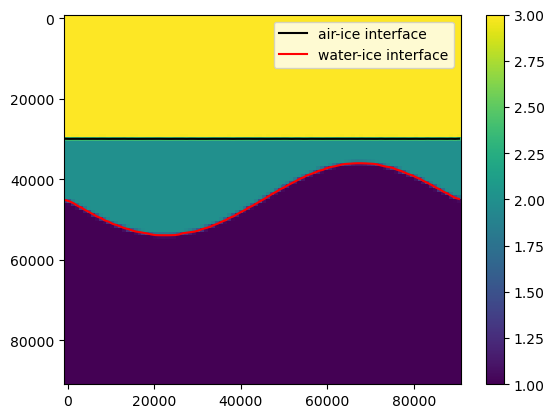

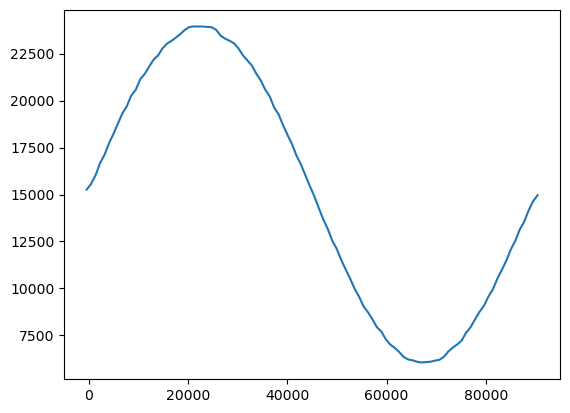

In [21]:
water_ice_interface = zeros(Float64,grid.nx+1)
air_ice_interface = zeros(Float64,grid.nx+1)
W = 90000.0
H = 90000.0

# Transfer materials to nodes
mat, = marker_to_stag(markers,grid,markers.integers[[markers.integerFields["material"]],:],"center")

function get_interface(grid::CartesianGrid,mat,contour_value)
    interface_position = zeros(Float64,grid.nx+1);
    for j in 1:grid.nx+1
        i = 1
        while i <= grid.ny
            if mat[i,j] == contour_value
                interface_position[j] = grid.yc[j]
                break
        elseif mat[i+1,j] < contour_value
                # interface is located within this cell.
                interface_position[j] = grid.yc[i] + (grid.yc[i+1]-grid.yc[i])/(mat[i+1,j]-mat[i,j])*(contour_value-mat[i,j])
                break
            end
            i = i +1
        end
    end
    return interface_position
end

water_ice_interface = get_interface(grid,mat,1.5)
air_ice_interface = get_interface(grid,mat,2.5)

figure()
pcolor(grid.xc,grid.yc,mat)
colorbar()
plot(grid.xc,air_ice_interface,"k",label="air-ice interface")
plot(grid.xc,water_ice_interface,"r",label="water-ice interface")
gca().invert_yaxis()
legend()
show()

figure()
plot(grid.xc,water_ice_interface-air_ice_interface)
show()

# Plots

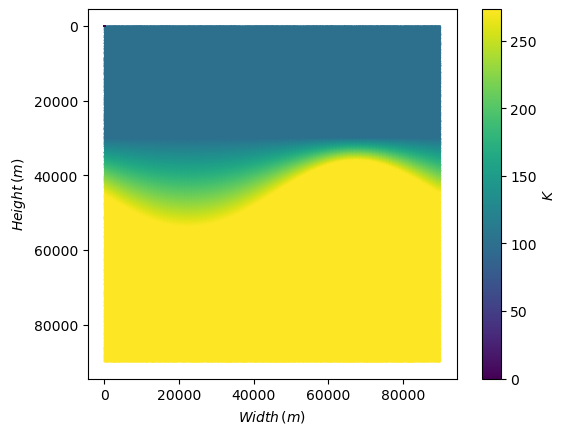

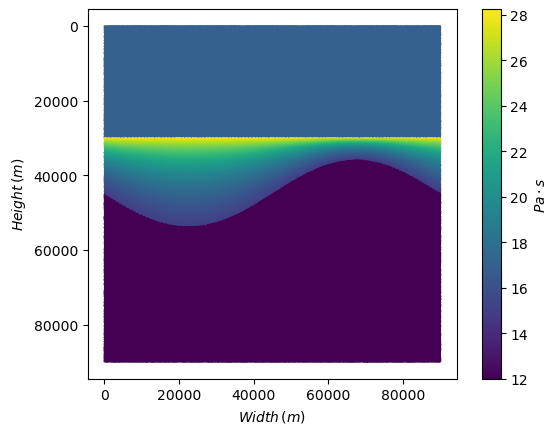

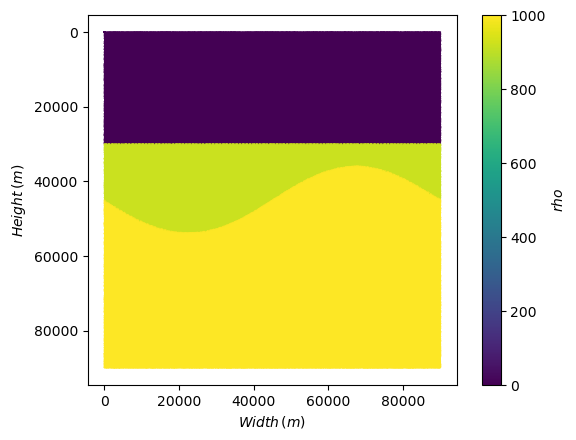

In [17]:
# Temperature Profile 
figure()
scatter(markers.x[1,:],markers.x[2,:],c=markers.scalars[markers.scalarFields["T"],:],s=0.1)
#title(L"Initial\,\,Temperature\,\,Profile")
#title(L"Temperature\,\,Profile\,\,at\,\,0.33\,Myr")
colorbar(label=L"K")
gca().invert_yaxis()
gca().set_aspect("equal")
gca().set_ylabel(L"Height\,(m)")
gca().set_xlabel(L"Width\,(m)")
show()

# Viscosity Profile 
figure()
scatter(markers.x[1,:],markers.x[2,:],c=log10.(markers.scalars[markers.scalarFields["eta"],:]),s=0.1)
#title(L"Initial\,\,Viscosity\,\,Profile")
#title(L"Viscosity\,\,Profile\,\,at\,\,0.33\,Myr")
colorbar(label=L"Pa\cdot{s}")
gca().invert_yaxis()
gca().set_aspect("equal")
gca().set_ylabel(L"Height\,(m)")
gca().set_xlabel(L"Width\,(m)")
show()

figure()
scatter(markers.x[1,:],markers.x[2,:],c=markers.scalars[markers.scalarFields["rho"],:],s=0.1)
colorbar(label=L"rho")
gca().invert_yaxis()
gca().set_aspect("equal")
gca().set_ylabel(L"Height\,(m)")
gca().set_xlabel(L"Width\,(m)")
show()


In [55]:
print("Creating eta at basic nodes matrix...")
@time display(eta_s)
print("Creating eta at cell center matrix...")
@time display(eta_n)
print("Creating vx matrix...")
@time display(vx)
print("Creating vy matrix...")
@time display(vy)
print("Creating rho matrix...")
@time display(rho_c)


Creating eta at basic nodes matrix...

101×100 Matrix{Float64}:
 1.0e17  1.0e17  1.0e17  1.0e17  1.0e17  …  1.00000e17  1.00000e17  1.0e17
 1.0e17  1.0e17  1.0e17  1.0e17  1.0e17     1.00000e17  1.0e17      1.0e17
 1.0e17  1.0e17  1.0e17  1.0e17  1.0e17     1.00000e17  1.0e17      1.0e17
 1.0e17  1.0e17  1.0e17  1.0e17  1.0e17     1.00000e17  1.0e17      1.0e17
 1.0e17  1.0e17  1.0e17  1.0e17  1.0e17     1.00000e17  1.0e17      1.0e17
 1.0e17  1.0e17  1.0e17  1.0e17  1.0e17  …  1.00000e17  1.0e17      1.0e17
 1.0e17  1.0e17  1.0e17  1.0e17  1.0e17     1.0e17      1.0e17      1.0e17
 1.0e17  1.0e17  1.0e17  1.0e17  1.0e17     1.00000e17  1.0e17      1.0e17
 1.0e17  1.0e17  1.0e17  1.0e17  1.0e17     1.0e17      1.0e17      1.0e17
 1.0e17  1.0e17  1.0e17  1.0e17  1.0e17     1.00000e17  1.0e17      1.0e17
 1.0e17  1.0e17  1.0e17  1.0e17  1.0e17  …  1.00000e17  1.0e17      1.0e17
 1.0e17  1.0e17  1.0e17  1.0e17  1.0e17     1.00000e17  1.0e17      1.0e17
 1.0e17  1.0e17  1.0e17  1.0e17  1.0e17     1.00000e17  1.0e17      1.0e17


  0.322132 seconds (666.58 k allocations: 35.201 MiB, 98.84% compilation time)
Creating eta at cell center matrix...

102×101 Matrix{Float64}:
 1.0e17      1.0e17  1.00000e17  1.0e17  …  1.0e17      1.0e17  1.0e17
 1.0e17      1.0e17  1.0e17      1.0e17     1.0e17      1.0e17  1.0e17
 1.00000e17  1.0e17  1.0e17      1.0e17     1.0e17      1.0e17  1.0e17
 1.00000e17  1.0e17  1.0e17      1.0e17     1.0e17      1.0e17  1.00000e17
 1.00000e17  1.0e17  1.0e17      1.0e17     1.0e17      1.0e17  1.0e17
 1.00000e17  1.0e17  1.0e17      1.0e17  …  1.0e17      1.0e17  1.0e17
 1.0e17      1.0e17  1.00000e17  1.0e17     1.0e17      1.0e17  1.0e17
 1.00000e17  1.0e17  1.0e17      1.0e17     1.0e17      1.0e17  1.0e17
 1.00000e17  1.0e17  1.0e17      1.0e17     1.0e17      1.0e17  1.0e17
 1.0e17      1.0e17  1.0e17      1.0e17     1.0e17      1.0e17  1.0e17
 1.0e17      1.0e17  1.0e17      1.0e17  …  1.0e17      1.0e17  1.0e17
 1.0e17      1.0e17  1.0e17      1.0e17     1.0e17      1.0e17  1.0e17
 1.0e17      1.0e17  1.0e17      1.0e17     1.00000e17  1.0e17  1.0e17
 ⋮                                       ⋱      

  0.003148 seconds (13.07 k allocations: 859.898 KiB)
Creating vx matrix...

102×101 Matrix{Float64}:
 0.0   5.79717e-19   1.15893e-18  …  3.39962e-18  1.70421e-18  0.0  0.0
 0.0   5.79717e-19   1.15893e-18     3.39962e-18  1.70421e-18  0.0  0.0
 0.0   5.79431e-19   1.15837e-18     3.40433e-18  1.70658e-18  0.0  0.0
 0.0   5.78868e-19   1.15725e-18     3.41372e-18  1.71131e-18  0.0  0.0
 0.0   5.78019e-19   1.15555e-18     3.42776e-18  1.71838e-18  0.0  0.0
 0.0   5.76879e-19   1.15328e-18  …  3.44638e-18  1.72775e-18  0.0  0.0
 0.0   5.75439e-19   1.15041e-18     3.46948e-18  1.73938e-18  0.0  0.0
 0.0   5.73688e-19   1.14692e-18     3.49693e-18  1.75321e-18  0.0  0.0
 0.0   5.71614e-19   1.14279e-18     3.52856e-18  1.76913e-18  0.0  0.0
 0.0   5.69203e-19   1.13799e-18     3.56415e-18  1.78704e-18  0.0  0.0
 0.0   5.66436e-19   1.13247e-18  …  3.60341e-18  1.8068e-18   0.0  0.0
 0.0   5.63294e-19   1.12622e-18     3.64599e-18  1.82823e-18  0.0  0.0
 0.0   5.59757e-19   1.11917e-18     3.69144e-18  1.85109e-18  0.0  0.0
 ⋮                                ⋱    

  0.003448 seconds (12.20 k allocations: 807.648 KiB)
Creating vy matrix...

102×101 Matrix{Float64}:
  0.0           0.0           0.0          …   0.0           0.0
 -5.739e-19    -5.739e-19    -5.73417e-19      1.68717e-18   1.68717e-18
 -1.14754e-18  -1.14754e-18  -1.14656e-18      3.37668e-18   3.37668e-18
 -1.72062e-18  -1.72062e-18  -1.71916e-18      5.07087e-18   5.07087e-18
 -2.29285e-18  -2.29285e-18  -2.29092e-18      6.77207e-18   6.77207e-18
 -2.86396e-18  -2.86396e-18  -2.86156e-18  …   8.48255e-18   8.48255e-18
 -3.43365e-18  -3.43365e-18  -3.43078e-18      1.02045e-17   1.02045e-17
 -4.0016e-18   -4.0016e-18   -3.99829e-18      1.19402e-17   1.19402e-17
 -4.5675e-18   -4.5675e-18   -4.56375e-18      1.36916e-17   1.36916e-17
 -5.13101e-18  -5.13101e-18  -5.12685e-18      1.54608e-17   1.54608e-17
 -5.69178e-18  -5.69178e-18  -5.68723e-18  …   1.72496e-17   1.72496e-17
 -6.24944e-18  -6.24944e-18  -6.24452e-18      1.90595e-17   1.90595e-17
 -6.8036e-18   -6.8036e-18   -6.79834e-18      2.08921e-17   2.08921e-17
  ⋮                               

  0.002759 seconds (9.61 k allocations: 646.320 KiB)
Creating rho matrix...

102×101 Matrix{Float64}:
    1.0     1.0     1.0     1.0     1.0  …     1.0     1.0     1.0     1.0
    1.0     1.0     1.0     1.0     1.0        1.0     1.0     1.0     1.0
    1.0     1.0     1.0     1.0     1.0        1.0     1.0     1.0     1.0
    1.0     1.0     1.0     1.0     1.0        1.0     1.0     1.0     1.0
    1.0     1.0     1.0     1.0     1.0        1.0     1.0     1.0     1.0
    1.0     1.0     1.0     1.0     1.0  …     1.0     1.0     1.0     1.0
    1.0     1.0     1.0     1.0     1.0        1.0     1.0     1.0     1.0
    1.0     1.0     1.0     1.0     1.0        1.0     1.0     1.0     1.0
    1.0     1.0     1.0     1.0     1.0        1.0     1.0     1.0     1.0
    1.0     1.0     1.0     1.0     1.0        1.0     1.0     1.0     1.0
    1.0     1.0     1.0     1.0     1.0  …     1.0     1.0     1.0     1.0
    1.0     1.0     1.0     1.0     1.0        1.0     1.0     1.0     1.0
    1.0     1.0     1.0     1.0     1.0        1.0     1.0     1.0     1.0


  0.003368 seconds (15.73 k allocations: 1020.641 KiB)
